In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from itertools import cycle, islice

In [2]:
# set chart style
sns.set_style("dark")
sns.set_context("notebook", font_scale=1.5, 
                rc={"lines.linewidth": 1.5})
colors = ['#91268F','#F05A28','#8CC63E','#00A7A0','#4C4C4C',
          '#BFE9E7','#7a2700']
sns.set(font="Pragmatica")

In [3]:
df = pd.read_csv(r'..\..\..\outputs\network\network_results.csv')

# Congested network components by time of day
df.columns

# Get freeflow from 20to5 period

# Exclude trips taken on non-designated facilities (facility_type == 0)
# These are artificial (weave lanes to connect HOV) or for non-auto uses 
df = df[df['data3'] != 0]    # data3 represents facility_type

# calculate total link VMT and VHT
df['VMT'] = df['@tveh']*df['length']
df['VHT'] = df['@tveh']*df['auto_time']/60

# Define facility type
df.loc[df['data3'].isin([1,2]), 'facility_type'] = 'highway'
df.loc[df['data3'].isin([3,4,6]), 'facility_type'] = 'arterial'
df.loc[df['data3'].isin([5]), 'facility_type'] = 'connector'

# Calculate delay
# Select links from overnight time of day
delay_df = df.loc[df['tod'] == '20to5'][['ij','auto_time']]
delay_df.rename(columns={'auto_time':'freeflow_time'}, inplace=True)

# Merge delay field back onto network link df
df = pd.merge(df, delay_df, on='ij', how='left')

# Calcualte hourly delay
df['total_delay'] = ((df['auto_time']-df['freeflow_time'])*df['@tveh'])/60    # sum of (volume)*(travtime diff from freeflow)

# Calcualte speed as a percent of freeflow
df['flow_index'] = df['auto_time']/df['freeflow_time']

df['county'] =df['@countyid'].map({33: 'King',
                                      35: 'Kitsap',
                                      53: 'Pierce',
                                      61: 'Snohomish'})

# FGTS

# Non-motorized extent in geographies

# High Capacity Transit Network

In [4]:
df['speed'] = df['length']/df['auto_time']*60
df['congestion_index'] = df['speed']/df['data2']
df['congestion_index'] = df['congestion_index'].clip(0,1)
df['congestion_category'] = pd.cut(df['congestion_index'], bins=[0,.25,.5,.7,1], labels=['Severe','Heavy','Moderate','Light'])

# Congestion by County Tables
### Total VMT & Percent of County VMT by Congestion Level

- **Severe: < 25% Speed Limit** (e.g., less than 15 mph on a road with speed limit of 60 mph)
- **Heavy: 25-50% Speed Limit** (e.g., 15-30 mph on a road with speed limit of 60 mph)
- **Moderate: 50-70% Speed Limit** (e.g, 30-42 mph on a road with speed limit of 60 mph)

#### All Day

In [5]:
# Percent of VMT by congestion category
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"35,404,388","4,228,218","15,754,322","13,826,915"
Moderate,"5,796,089","92,010","2,017,213","1,302,171"
Heavy,"3,013,641","53,621","697,829","586,669"
Severe,"258,225","3,424","55,702","38,054"


In [6]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,79.6%,96.6%,85.0%,87.8%
Moderate,13.0%,2.1%,10.9%,8.3%
Heavy,6.8%,1.2%,3.8%,3.7%
Severe,0.6%,0.1%,0.3%,0.2%


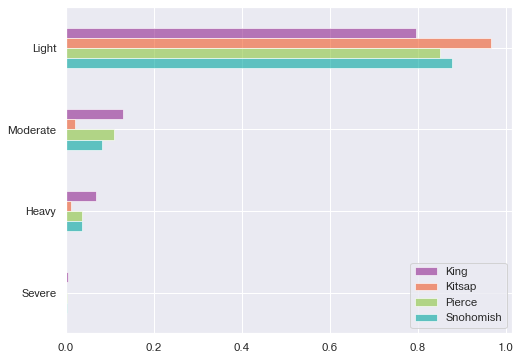

In [7]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

**Freeway** VMT by Congestion Category

In [8]:
# Segment by facility type
_df = df[df['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"17,844,685","1,912,260","6,788,774","6,841,743"
Moderate,"3,911,525","16,661","1,234,421","789,506"
Heavy,"1,993,599","22,757","373,244","316,835"
Severe,"76,857",611,"23,725","9,489"


**Arterial** VMT by Congestion Category

In [9]:
# Segment by facility type
_df = df[df['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"15,213,231","1,942,725","7,744,949","5,848,840"
Moderate,"1,884,563","75,349","782,792","512,665"
Heavy,"1,013,820","30,864","324,586","269,833"
Severe,"181,367","2,813","31,977","28,566"


#### AM Peak (7 to 8 AM)

In [10]:
pd.options.display.float_format = '{:0,.0f}'.format
df_am = df[df['tod'] == '7to8']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,180,987","302,359","959,362","912,938"
Moderate,"555,363","10,072","299,716","142,834"
Heavy,"503,015","8,557","138,746","118,869"
Severe,"33,750",283,"25,575","3,983"


In [11]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,66.6%,94.1%,67.4%,77.5%
Moderate,17.0%,3.1%,21.1%,12.1%
Heavy,15.4%,2.7%,9.7%,10.1%
Severe,1.0%,0.1%,1.8%,0.3%


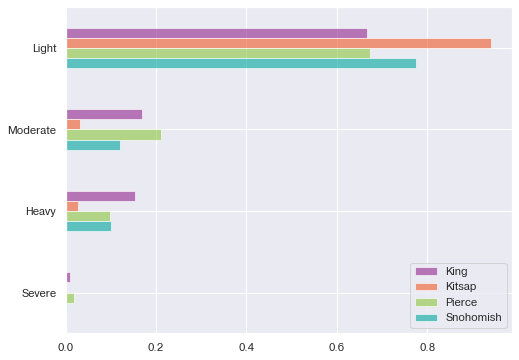

In [12]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

AM Peak **Freeway** VMT

In [13]:
# Segment by facility type
_df = df_am[df_am['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"989,543","143,283","320,868","453,266"
Moderate,"367,632","4,541","221,175","79,979"
Heavy,"397,535","6,229","101,267","92,363"
Severe,"13,977",0,"21,938",714


AM Peak **Arterial** VMT

In [14]:
# Segment by facility type
_df = df_am[df_am['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,052,078","138,178","562,335","392,431"
Moderate,"187,731","5,532","78,542","62,856"
Heavy,"105,018","2,328","37,479","26,506"
Severe,"19,773",283,"3,637","3,270"


#### PM Peak (5 to 6 PM)

In [15]:
pd.options.display.float_format = '{:0,.0f}'.format
df_pm = df[df['tod'] == '17to18']
_df = df_am.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,180,987","302,359","959,362","912,938"
Moderate,"555,363","10,072","299,716","142,834"
Heavy,"503,015","8,557","138,746","118,869"
Severe,"33,750",283,"25,575","3,983"


In [16]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,66.6%,94.1%,67.4%,77.5%
Moderate,17.0%,3.1%,21.1%,12.1%
Heavy,15.4%,2.7%,9.7%,10.1%
Severe,1.0%,0.1%,1.8%,0.3%


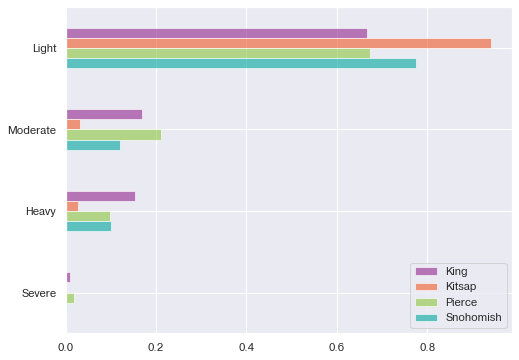

In [17]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

PM **Freeway** VMT

In [18]:
# Segment by facility type
_df = df_pm[df_pm['facility_type'] == 'highway']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,020,928","154,884","348,592","452,126"
Moderate,"456,186",872,"209,003","132,005"
Heavy,"345,064","5,349","110,117","57,134"
Severe,"17,059",174,621,801


PM **Arterial** VMT

In [19]:
# Segment by facility type
_df = df_pm[df_pm['facility_type'] == 'arterial']
pd.options.display.float_format = '{:0,.0f}'.format
_df = _df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='VMT')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"1,224,270","157,401","629,228","459,205"
Moderate,"220,216","6,305","90,069","65,025"
Heavy,"115,807","3,137","39,800","30,511"
Severe,"23,532",256,"4,058","4,081"


# Freight Congestion
## All Trucks (Heavy & Medium)
#### All Day

In [20]:
df['heavy_truck_vmt'] = df['length']*df['@heavy_truck']
df['medium_truck_vmt'] = df['length']*df['@medium_truck']
df['total_truck_vmt'] = df['heavy_truck_vmt']+df['medium_truck_vmt'] 

In [21]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='total_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"4,932,565","407,372","1,741,217","1,849,348"
Moderate,"892,306","6,645","259,998","162,766"
Heavy,"417,367","3,897","70,387","56,405"
Severe,"22,868",199,"5,297","2,319"


In [22]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,78.7%,97.4%,83.8%,89.3%
Moderate,14.2%,1.6%,12.5%,7.9%
Heavy,6.7%,0.9%,3.4%,2.7%
Severe,0.4%,0.0%,0.3%,0.1%


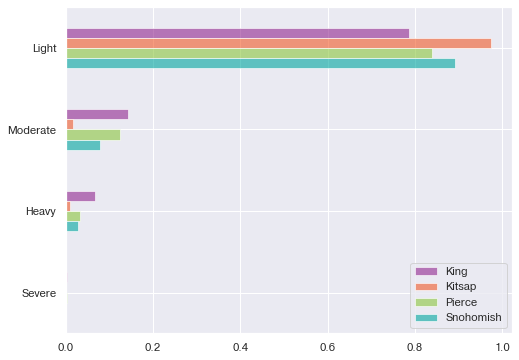

In [23]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

## Heavy Trucks

In [24]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='heavy_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,458,247","163,124","982,541","1,066,074"
Moderate,"444,829","1,805","153,898","87,692"
Heavy,"196,271","1,195","42,626","25,870"
Severe,"8,108",76,"3,842",454


In [25]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,79.1%,98.1%,83.1%,90.3%
Moderate,14.3%,1.1%,13.0%,7.4%
Heavy,6.3%,0.7%,3.6%,2.2%
Severe,0.3%,0.0%,0.3%,0.0%


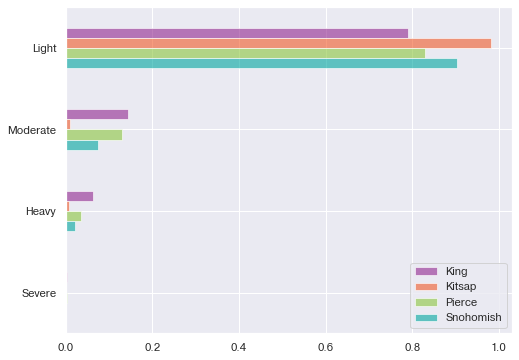

In [26]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');

## Medium Trucks

In [27]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='medium_truck_vmt')

_df

county,King,Kitsap,Pierce,Snohomish
congestion_category,,,,
Severe,"14,760",123,"1,454","1,865"
Heavy,"221,097","2,703","27,761","30,535"
Moderate,"447,477","4,840","106,100","75,074"
Light,"2,474,317","244,248","758,676","783,275"


In [28]:
pd.options.display.float_format = '{:0,.0f}'.format
_df = df.pivot_table(index='congestion_category',columns='county',
               aggfunc='sum',values='medium_truck_vmt')
_df = _df.reindex(['Light','Moderate','Heavy','Severe'])
_df.index.name = None
_df.columns.name = None
_df

,King,Kitsap,Pierce,Snohomish
Light,"2,474,317","244,248","758,676","783,275"
Moderate,"447,477","4,840","106,100","75,074"
Heavy,"221,097","2,703","27,761","30,535"
Severe,"14,760",123,"1,454","1,865"


In [29]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = _df/_df.sum(axis=0)
_df

,King,Kitsap,Pierce,Snohomish
Light,78.4%,97.0%,84.9%,87.9%
Moderate,14.2%,1.9%,11.9%,8.4%
Heavy,7.0%,1.1%,3.1%,3.4%
Severe,0.5%,0.0%,0.2%,0.2%


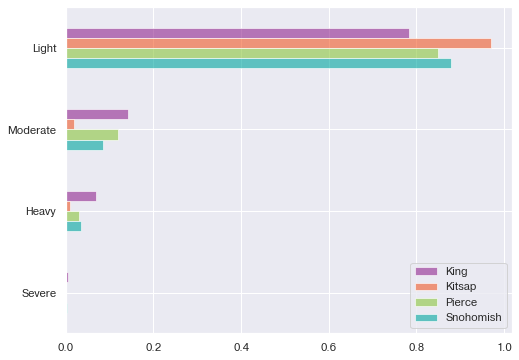

In [30]:
my_colors = list(islice(cycle(colors), None, len(_df)))
ax = _df.plot(kind='barh', alpha=0.6, color=colors, figsize=(8,6))
ax.invert_yaxis()
ax.legend(loc='lower right');